In [ ]:
!pip install pmdarima


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.3 MB/s 
     |████████████████████████████████| 9.8 MB 44.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 23.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math
import yfinance as yf
import datetime as dt

In [ ]:

ticker = 'AAPL'

#Define the start and end date for the historical data
today = dt.datetime.now()
start = dt.date(today.year-1, today.month-5, today.day-16)
end = dt.date(today.year, today.month, today.day)

#Fetch data using yfinance download function.
df_close = yf.download(tickers=ticker, start=start, end=end, interval='1h',)[['Close']]

df_close

[*********************100%***********************]  1 of 1 completed


,Close
2021-01-08 09:30:00-05:00,130.380005
2021-01-08 10:30:00-05:00,131.070007
2021-01-08 11:30:00-05:00,132.154999
2021-01-08 12:30:00-05:00,131.115005
2021-01-08 13:30:00-05:00,131.475006
...,...
2022-06-23 11:30:00-04:00,136.789993
2022-06-23 12:30:00-04:00,136.429993
2022-06-23 13:30:00-04:00,137.299896
2022-06-23 14:30:00-04:00,137.899994


In [ ]:
# df_close = stock_data[['Close']]


In [ ]:
# Determine whether a series is stationary using the Augmented Dickey Fuller (ADF) Test
result = adfuller(df_close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -1.637653
p-value: 0.463488


In [ ]:
train_data, test_data = df_close[:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]


In [ ]:
# Use Auto ARIMA to find the best p,d,q parameters
model_autoARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6228.746, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6230.340, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6230.338, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6227.078, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6232.364, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.448 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2310
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3112.539
Date:                Fri, 24 Jun 2022   AIC                           6227.078
Time:                        07:22:43   BIC                           6232.823
Sample:                             0   HQIC                          6229.172
                               - 2310                                       

In [ ]:
# Extract best arima parameters
best_parameters = model_autoARIMA.get_params().get("order")
best_parameters

(0, 1, 0)

In [ ]:
# Build Model
model = ARIMA(train_data, order=best_parameters)  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2310
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3112.539
Date:                Fri, 24 Jun 2022   AIC                           6227.078
Time:                        07:42:33   BIC                           6232.823
Sample:                             0   HQIC                          6229.172
                               - 2310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.8677      0.013     68.674      0.000       0.843       0.892
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):              3668.39
Prob(Q):                              0.52   Pr

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Construct the forecasts
fcast = fitted.get_forecast(len(test_data)).summary_frame()
fcast.index = test_data.index


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


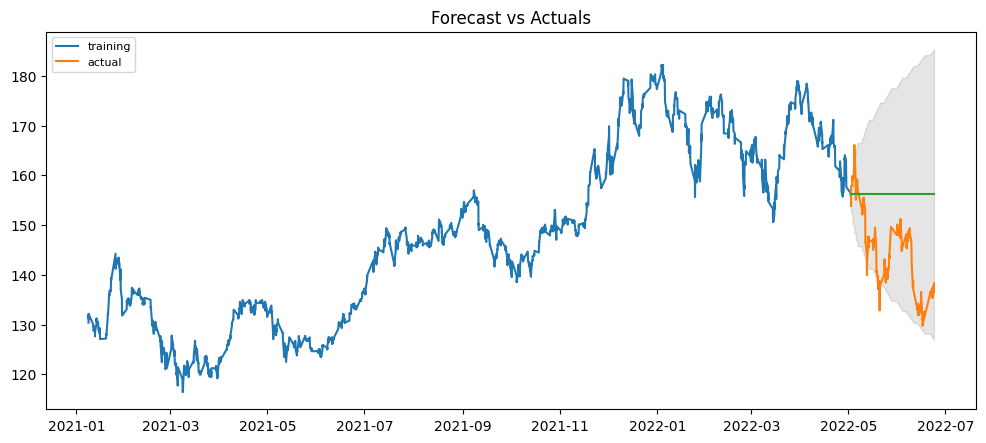

In [ ]:

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fcast['mean'])

plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
forecast = fitted.forecast(len(test_data))
forecast

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


2310    156.175507
2311    156.175507
2312    156.175507
2313    156.175507
2314    156.175507
           ...    
2562    156.175507
2563    156.175507
2564    156.175507
2565    156.175507
2566    156.175507
Name: predicted_mean, Length: 257, dtype: float64

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import yfinance as yf
import datetime as dt


def getdata():
  #Set the cryptocurrency tickers to get the data
  ticker = 'AAPL'

  #Define the start and end date for the historical data   
  today = dt.datetime.now()
  start = dt.date(today.year-1, today.month-5, today.day-16)
  end = dt.date(today.year, today.month, today.day)

  #Fetch bitcoin data using yfinance download function.
  df_close = yf.download(tickers=ticker, start=start, end=end, interval='1h',)[['Close']]

  return df_close

df_close = getdata()
train_data, test_data = df_close[:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]

def auto_arima(train_data=train_data):
  model_autoARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
  best_parameters = model_autoARIMA.get_params().get("order")
  return best_parameters

best_parameters = arima_model()

def build_model_and_forcast(train_data=train_data):
  #build model
  model = ARIMA(train_data, order=best_parameters)  
  #fit the model
  fitted = model.fit()
  #make a forecast
  forecast = fitted.forecast(len(test_data))
  print(forecast)
  return forecast


def run(request):
  build_model_and_forcast()




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import yfinance as yf
import datetime as dt


def getdata():
  #Set the cryptocurrency tickers to get the data
  ticker = 'AAPL'

  #Define the start and end date for the historical data   
  today = dt.datetime.now()
  start = dt.date(today.year-1, today.month-5, today.day-16)
  end = dt.date(today.year, today.month, today.day)

  #Fetch bitcoin data using yfinance download function.
  df_close = yf.download(tickers=ticker, start=start, end=end, interval='1h',)[['Close']]
  return df_close



In [ ]:
lose = getdata()
lose

[*********************100%***********************]  1 of 1 completed


,Close
2021-01-08 09:30:00-05:00,130.380005
2021-01-08 10:30:00-05:00,131.070007
2021-01-08 11:30:00-05:00,132.154999
2021-01-08 12:30:00-05:00,131.115005
2021-01-08 13:30:00-05:00,131.475006
...,...
2022-06-23 11:30:00-04:00,136.789993
2022-06-23 12:30:00-04:00,136.429993
2022-06-23 13:30:00-04:00,137.299896
2022-06-23 14:30:00-04:00,137.899994


pmdarima  
yfinance  
pandas  
matplotlib  
